The purpose of this notebook is to demonstrate how to use the cell_type_mapper to map to a subset of a taxonomy. We will demonstrate this by mapping the non-neuronal data from the Siletti et al. 2023 Whole Human Brain dataset onto the SEA-AD MTG taxonomy. We will first map the data to the full SEA-AD taxonomy, and then map it onto the SEA-AD, limiting to the non-neuronal branch of the taxonomy.

In [1]:
import os
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
import pathlib
import json
import anndata

cache_dir = pathlib.Path('data/abc_cache')
if not cache_dir.exists():
    cache_dir.mkdir()
dst_dir = pathlib.Path('data/subset_test')
if not dst_dir.exists():
    dst_dir.mkdir()

## Download data artifacts to support running MapMyCells

In [3]:
from cell_type_mapper.test_utils.cache_wrapper import AbcCacheWrapper

In [4]:
abc_cache = AbcCacheWrapper.from_cache_dir(cache_dir)

#### Download database for gene mapping

In [5]:
gene_mapper_db_path = abc_cache.get_data_path(
    directory='mmc-gene-mapper',
    file_name='mmc_gene_mapper.2025-08-04'
)

#### Download file defining SEA-AD MTG taxonomy

In [6]:
precomputed_stats_path = abc_cache.get_data_path(
    directory='SEAAD-taxonomy',
    file_name='precomputed_stats.20231120.sea_ad.MTG'
)

#### Download example data to map to taxonomy

In [7]:
full_data_path = abc_cache.get_data_path(
    directory='WHB-10Xv3',
    file_name='WHB-10Xv3-Nonneurons/raw'
)


#### Downsample data to map to taxonomy
(so the mapping doesn't take forever)

In [8]:
%%time
query_path = dst_dir / 'query_data.h5ad'
src = anndata.read_h5ad(full_data_path, backed='r')
query = src[100000:300000]
query.write_h5ad(query_path)
src.file.close()
del src

CPU times: user 16 s, sys: 2.63 s, total: 18.6 s
Wall time: 20.5 s


## Map example data to full taxonomy

In [9]:
from cell_type_mapper.cli.map_to_on_the_fly_markers import OnTheFlyMapper

In [10]:
csv_dst_path = dst_dir / 'full_taxonomy_mapping.csv'
json_dst_path = dst_dir / 'full_taxonomy_mapping.json'

In [11]:
config = {
    'gene_mapping': {
        'db_path': str(gene_mapper_db_path)
    },
    'precomputed_stats': {
        'path': str(precomputed_stats_path)
    },
    'type_assignment': {
        'bootstrap_factor': 0.5,
        'normalization': 'raw'
    },
    'query_markers': {
        'n_per_utility': 15
    },
    'reference_markers': {
        'n_valid': 30
    },
    'query_path': str(query_path),
    'csv_result_path': str(csv_dst_path),
    'extended_result_path': str(json_dst_path),
    'n_processors': 4,
    'verbose_stdout': False
}

In [12]:
print(json.dumps(config, indent=2))

{
  "gene_mapping": {
    "db_path": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/mmc-gene-mapper/20250630/mmc_gene_mapper.2025-08-04.db"
  },
  "precomputed_stats": {
    "path": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/SEAAD-taxonomy/20240831/precomputed_stats.20231120.sea_ad.MTG.h5"
  },
  "type_assignment": {
    "bootstrap_factor": 0.5,
    "normalization": "raw"
  },
  "query_markers": {
    "n_per_utility": 15
  },
  "reference_markers": {
    "n_valid": 30
  },
  "query_path": "data/subset_test/query_data.h5ad",
  "csv_result_path": "data/subset_test/full_taxonomy_mapping.csv",
  "extended_result_path": "data/subset_test/full_taxonomy_mapping.json",
  "n_processors": 4,
  "verbose_stdout": false
}


In [13]:
%%time
mapper = OnTheFlyMapper(
    args=[],
    input_data=config
)
mapper.run()

***Checking to see if we need to map query genes onto reference dataset
====Based on 36555 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Reference data belongs to species Homo sapiens Linnaeus, 1758:9606
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Homo sapiens Linnaeus, 1758:9606 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.1
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 59357 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Input genes are from species 'Homo sapiens Linnaeus, 1758:9606'
***Mapping of query genes to reference dataset complete
starting to find reference markers
writing /var/folders/8b/hnw5vq8s20jbpz51wdhd11fr0000gp/T/tmpe_19lgis/tmpn5glkofa/reference_markers.20231120.sea_ad.MTG.h5
Starting precomputed_stats.20231120.sea_ad.MTG.h5
1192 of 9591 taxon pairs in 7.69e+00 se

/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


No gene_mapper_db provided. Assuming that query genes have already been mapped to the same species/authority as reference genes.
BENCHMARK: spent 2.6633e-02 seconds creating query marker cache
Scanning unlabeled data to check that it is >= 0
Verified that unlabeled data is >= 0
Running CPU implementation of type assignment.
60000 of 200000 cells in 6.35e-01 min; predict 1.48e+00 min of 2.12e+00 min left
90000 of 200000 cells in 9.02e-01 min; predict 1.10e+00 min of 2.01e+00 min left
120000 of 200000 cells in 7.02e+01 sec; predict 4.68e+01 sec of 1.17e+02 sec left
150000 of 200000 cells in 8.60e+01 sec; predict 2.87e+01 sec of 1.15e+02 sec left
180000 of 200000 cells in 1.02e+02 sec; predict 1.13e+01 sec of 1.13e+02 sec left
BENCHMARK: spent 1.1132e+02 seconds assigning cell types
Writing marker genes to output file
FILE TRACKER: cleaning up ../file_tracker_os9jll9h
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP
MAPPING FROM ON-THE-FLY MARKERS RAN SUCCESSFULLY
CPU times: us

## Plot distribution of bootstrapping_probability of cells assigned to different classes

Recall that we specifically downloaded the non-neuronal data from the Siletti et al. 2023 dataset, so we should not expect any cells to appear in the "Neuronal: GABAergic" and "Neuronal: Glutamatergic" classes.

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
result_df = pd.read_csv(csv_dst_path, comment='#')

In [16]:
print(set(result_df.class_name.values))

{'Neuronal: GABAergic', 'Neuronal: Glutamatergic', 'Non-neuronal and Non-neural'}


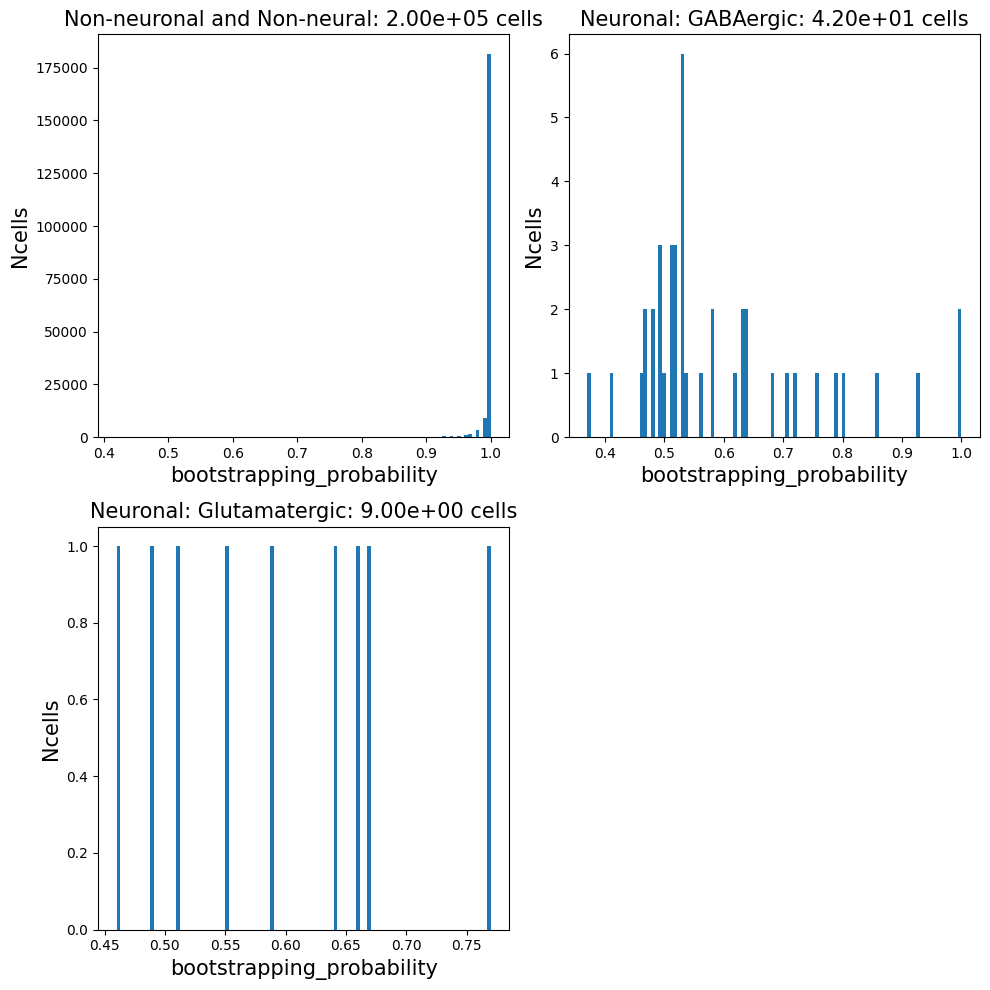

In [17]:
fontsize = 15
fig = plt.figure(figsize=(10, 10))
axis_list = [fig.add_subplot(2, 2, ii+1) for ii in range(3)]
for ii, class_name in enumerate(('Non-neuronal and Non-neural', 'Neuronal: GABAergic', 'Neuronal: Glutamatergic')):
    subset = result_df[result_df.class_name == class_name]
    axis = axis_list[ii]
    title = f'{class_name}: {len(subset):.2e} cells'
    axis.set_title(title, fontsize=fontsize)
    prob = subset.class_bootstrapping_probability.values
    _ = axis.hist(prob, bins=100)
    axis.set_xlabel('bootstrapping_probability', fontsize=fontsize)
    axis.set_ylabel('Ncells', fontsize=fontsize)
fig.tight_layout()

## Map data to a truncated taxonomy
Use the `nodes_to_drop` configuration parameter to drop the two "Neuronal" classes from the taxonomy, forcing every cell to be mapped to the "Non-neuronal and Non-neural" class.

In [18]:
dropped_csv_dst_path = dst_dir / 'trimmed_taxonomy_mapping.csv'
dropped_json_dst_path = dst_dir / 'trimmed_taxonomy_mapping.json'

In [19]:
drop_config = {
    'gene_mapping': {
        'db_path': str(gene_mapper_db_path)
    },
    'precomputed_stats': {
        'path': str(precomputed_stats_path)
    },
    'type_assignment': {
        'bootstrap_factor': 0.5,
        'normalization': 'raw'
    },
    'query_markers': {
        'n_per_utility': 15
    },
    'reference_markers': {
        'n_valid': 30
    },
    'query_path': str(query_path),
    'csv_result_path': str(dropped_csv_dst_path),
    'extended_result_path': str(dropped_json_dst_path),
    'n_processors': 4,
    'verbose_stdout': False,
    'nodes_to_drop': [
        ('class', 'Neuronal: Glutamatergic'),
        ('class', 'Neuronal: GABAergic')
    ]
}

In [20]:
print(json.dumps(drop_config, indent=2))

{
  "gene_mapping": {
    "db_path": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/mmc-gene-mapper/20250630/mmc_gene_mapper.2025-08-04.db"
  },
  "precomputed_stats": {
    "path": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/SEAAD-taxonomy/20240831/precomputed_stats.20231120.sea_ad.MTG.h5"
  },
  "type_assignment": {
    "bootstrap_factor": 0.5,
    "normalization": "raw"
  },
  "query_markers": {
    "n_per_utility": 15
  },
  "reference_markers": {
    "n_valid": 30
  },
  "query_path": "data/subset_test/query_data.h5ad",
  "csv_result_path": "data/subset_test/trimmed_taxonomy_mapping.csv",
  "extended_result_path": "data/subset_test/trimmed_taxonomy_mapping.json",
  "n_processors": 4,
  "verbose_stdout": false,
  "nodes_to_drop": [
    [
      "class",
      "Neuronal: Glutamatergic"
    ],
    [
      "class",
      "Neuronal: GABAergic"
    ]
  ]
}


In [21]:
%%time
mapper = OnTheFlyMapper(
    args=[],
    input_data=drop_config
)
mapper.run()

***Checking to see if we need to map query genes onto reference dataset
====Based on 36555 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Reference data belongs to species Homo sapiens Linnaeus, 1758:9606
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Homo sapiens Linnaeus, 1758:9606 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.1
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 59357 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Input genes are from species 'Homo sapiens Linnaeus, 1758:9606'
***Mapping of query genes to reference dataset complete
starting to find reference markers
writing /var/folders/8b/hnw5vq8s20jbpz51wdhd11fr0000gp/T/tmppndw6zkb/tmp8kkjuv2b/reference_markers.20231120.sea_ad.MTG.h5izp81ir5.h5
Starting precomputed_stats.20231120.sea_ad.MTG.h5izp81ir5.h5


/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


144 of 435 taxon pairs in 6.54e+00 sec; predict 1.32e+01 sec of 1.98e+01 sec left
288 of 435 taxon pairs in 1.01e+01 sec; predict 5.16e+00 sec of 1.53e+01 sec left
432 of 435 taxon pairs in 1.41e+01 sec; predict 9.76e-02 sec of 1.42e+01 sec left
480 of 435 taxon pairs in 1.41e+01 sec; predict -1.33e+00 sec of 1.28e+01 sec left
Initial marker discovery took 1.42e+01 seconds
joining took 3.111124e-03 seconds
joining took 2.846956e-03 seconds
Transposing markers took 4.76e-01 seconds
Copying to /var/folders/8b/hnw5vq8s20jbpz51wdhd11fr0000gp/T/tmppndw6zkb/tmp8kkjuv2b/reference_markers.20231120.sea_ad.MTG.h5izp81ir5.h5 took 5.16e-04 seconds
Wrote reference_markers.20231120.sea_ad.MTG.h5izp81ir5.h5
REFERENCE MARKER FINDER RAN SUCCESSFULLY
completed in 1.47e+01 seconds
found reference markers


/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


found markers for 2 parents in 2.29e-02 minutes; predict 6.88e-02 of 9.18e-02 remaining
found markers for 3 parents in 2.94e-02 minutes; predict 4.90e-02 of 7.84e-02 remaining
found markers for 4 parents in 3.59e-02 minutes; predict 3.59e-02 of 7.19e-02 remaining
found markers for 5 parents in 4.27e-02 minutes; predict 2.56e-02 of 6.83e-02 remaining
QUERY MARKER FINDER RAN SUCCESSFULLY in 3.79e+00 seconds
found query markers
=== Running Hierarchical Mapping 1.6.0 

ENV: is_torch_available: False
ENV: is_cuda_available: False
ENV: use_torch: False
ENV: multiprocessing start method: spawn
ENV: Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 12:55:12) [Clang 14.0.6 ]
ENV: anndata version: 0.12.2
ENV: numpy version: 2.2.6
FILE TRACKER: copied ../query_data.h5ad to ../query_data_pn_yctf_.h5ad
FILE TRACKER: copied ../precomputed_stats.20231120.sea_ad.MTG.h5izp81ir5.h5 to ../precomputed_stats.20231120.sea_ad.MTGizp81ir5_p8j5h54t.h5
BENCHMARK: spent 1.2684e+00 seconds

### Examine the results of the truncated mapping
see that only one class is present in the mapping now

In [22]:
dropped_result_df = pd.read_csv(dropped_csv_dst_path, comment='#')
print(set(dropped_result_df.class_name))

{'Non-neuronal and Non-neural'}


To verify that this is not just a trick of statistics, we will load the metadata from the two mappings and look at how may classes are present in the taxonomies to which the data was mapped.

In [23]:
with open(json_dst_path, 'rb') as src:
    full_mapping = json.load(src)
with open(dropped_json_dst_path, 'rb') as src:
    dropped_mapping = json.load(src)

The full taxonomy mapping lists all three classes

In [24]:
print(full_mapping['taxonomy_tree']['CCN20230505_CLAS'].keys())

dict_keys(['CS20230505_CLAS_0001', 'CS20230505_CLAS_0002', 'CS20230505_CLAS_0003'])


The truncated mapping lists only one class (the non-neuronal class)

In [25]:
print(dropped_mapping['taxonomy_tree']['CCN20230505_CLAS'].keys())

dict_keys(['CS20230505_CLAS_0003'])


## How to run the truncated mapping from the command line

In [26]:
!python -m cell_type_mapper.cli.map_to_on_the_fly_markers \
--gene_mapping.db_path "data/abc_cache/mapmycells/mmc-gene-mapper/20250630/mmc_gene_mapper.2025-08-04.db" \
--precomputed_stats.path "data/abc_cache/mapmycells/SEAAD-taxonomy/20240831/precomputed_stats.20231120.sea_ad.MTG.h5" \
--type_assignment.bootstrap_factor 0.5 \
--type_assignment.normalization "raw" \
--query_markers.n_per_utility 15 \
--reference_markers.n_valid 30 \
--query_path "data/subset_test/query_data.h5ad" \
--csv_result_path "data/subset_test/dropped_taxonomy_mapping.cli.csv" \
--extended_result_path "data/subset_test/dropped_taxonomy_mapping.cli.json" \
--n_processors 4 \
--verbose_stdout False \
--nodes_to_drop '[["class", "Neuronal: Glutamatergic"], ["class", "Neuronal: GABAergic"]]'

***Checking to see if we need to map query genes onto reference dataset
====Based on 36555 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Reference data belongs to species Homo sapiens Linnaeus, 1758:9606
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Homo sapiens Linnaeus, 1758:9606 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.1
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 59357 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Input genes are from species 'Homo sapiens Linnaeus, 1758:9606'
***Mapping of query genes to reference dataset complete
starting to find reference markers
writing /var/folders/8b/hnw5vq8s20jbpz51wdhd11fr0000gp/T/tmpvt26jed3/tmpftas5pzi/reference_markers.20231120.sea_ad.MTG.h5xkdy2jej.h5
/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper

Again: we have mapped to a taxonomy with a single class

In [27]:
with open("data/subset_test/dropped_taxonomy_mapping.cli.json", "rb") as src:
    cli_mapping = json.load(src)

In [28]:
print(cli_mapping['taxonomy_tree']['CCN20230505_CLAS'].keys())

dict_keys(['CS20230505_CLAS_0003'])
